In [6]:
# Package and environment loading
import random
import numpy as np
import tensorflow as tf
from tic_env import TictactoeEnv, OptimalPlayer
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [7]:
def Net(n_hidden = 128):
  """
  Fully Conncected Neural Network with:
  - input of shape (3,3,2)
  - two hidden layers with n_hidden hidden neurons and ReLu as activation function
  - output layer of shape (1,9) and linear activation function
  """
  # Input layer
  inputs = layers.Input(shape=(3,3,2))
  flatten = layers.Flatten()(inputs) # flattening a input of (3,3,2) to (18,1)
  # Hidden layers
  layer1 = layers.Dense(n_hidden,activation="relu")(flatten)
  layer2 = layers.Dense(n_hidden,activation="relu")(layer1)
  # Output layer
  outputs = layers.Dense(9,activation ="linear")(layer2)

  return keras.Model(inputs=inputs,outputs=outputs)

In [8]:
class DQPlayer:
  """
  Class implementing the deep Q-player. 
  ATTRIBUTES: 
  - epsilon: exploration rate
  - player_name: player name (X or O)
  - model: net Net()
  - model_target: target net Net()
  - loss_function: Huber loss
  """
  def __init__(self, epsilon, player_name = 'O'):
    self.epsilon = epsilon #exploration rate
    self.player_name = player_name
    self.model = Net() 
    self.model_target = Net()
    self.loss_function = keras.losses.Huber()

  def set_player(self, player_name = 'O', j=-1):
        """
        Function to set player symbol, needed to alternate the starting player.
        INPUTS:
        - player_name: player symbol on the board
        - j : number of the current game
        """
        self.player_name = player_name
        if j != -1:
            self.player_name = 'O' if j % 2 == 0 else 'X'

  def set_epsilon(self, epsilon):
        """
        Functions that sets the exploration level.
        INPUTS:
        - epsilon: exploration level
        """
        self.epsilon = epsilon
    

In [9]:
class DQLearning:
  """
  Class implementing the Deep Q-learning algorithm (DQN) against the eps-optimal player
  """
  def __init__(self, epsilon, epsilon_opponent = 0.5, alpha = 1e-3, gamma = 0.99, player_name = 'O', N = 20000, n_train = 250, n_test = 500, buffer_size = 10000, batch_size = 64, test = False):
    self.epsilon = epsilon #exploration rate of the q-player 
    self.alpha = alpha  #learning rate
    self.gamma = gamma  #discount factor 
    self.dq_player = DQPlayer(epsilon) #dq-player
    self.opponent = OptimalPlayer(epsilon_opponent) #optimal player 
    self.env = TictactoeEnv()

    
    self.optimizer = keras.optimizers.Adam(learning_rate = self.alpha)
    self.N = N  #total number of training games
    self.n_train = n_train #number of training games between test
    self.n_test = n_test #number of games for test
    self.test = test #bool, true if we want to compute M_rand and M_opt
    self.batch_size = batch_size
    
    self.action_history = [] #vector collecting consecutive actions
    self.state_history = []  #vector collecting consecutive states 
    self.state_next_history = [] #vector collecting consecutive (next) states. Differs from the previous for the first and last elements
    self.rewards_history = [] #vector collecting consecutive history
    self.done_history = [] #vector collecting consecutive values of self.env.end

    self.episode_reward_history = [] #vector collecting dq-player rewards 
    self.loss_history = [] #vector collecting loss values at the end of consecutive games
    self.reward_mean = [] 
    self.loss_mean = []

    self.M_rand = []
    self.M_opt = []

    self.episode_count = 0 # game counter
    self.num_actions = 9 # number of actions available

    self.max_memory_length = buffer_size # buffer size
    self.update_target_network = 500 # how often to update the target network

     # Huber loss

  def build_tensor(self, grid, player_name):
      """
      Functions that builds the tensor from the current grid.
      INPUTS:
      - grid: current grid
      - player_name: name of the dq-player 
      """
      my_state = grid.copy()
      opp_state = grid.copy()
      if player_name == 'X':
        my_state[my_state ==-1.] = 0.
        opp_state[opp_state==1.] = 0.
        opp_state[opp_state==-1.] = 1.
      if player_name == 'O':
        my_state[my_state==1.] = 0.
        my_state[my_state==-1.] = 1.
        opp_state[opp_state==-1.] = 0.

      my_tstate = tf.convert_to_tensor(my_state)
      opp_tstate = tf.convert_to_tensor(opp_state)

      ret_tensor = tf.stack([my_tstate,opp_tstate], axis = 2)

      ret_tensor = tf.reshape(ret_tensor, shape = [1,3,3,2])

      return ret_tensor

    
  def training(self):
    """
    Functions that runs self.N training games. If self.test = true, it runs self.n_test every self.n_train trainings.
    """
    self.episode_count = 0
    while True:  # Run until solved, i.e. while episode_count < self.N
        self.dq_player.set_epsilon(self.epsilon[self.episode_count])
        self.episode_count += 1
        state,_,_=self.env.reset()
        done = False
        episode_reward = 0
        #switch of the starting player
        self.dq_player.set_player('O', self.episode_count)
        self.opponent.set_player('X', self.episode_count)

        #first move if the starting player is the optimal player
        if self.env.current_player == self.opponent.player:
          move = self.opponent.act(state)
          state,_,_ = self.env.step(move)

        while not done: # while the game is not over
          state_tensor = self.build_tensor(state,self.dq_player.player_name)

          #action of the dq-player
          if self.dq_player.epsilon > np.random.rand(1)[0]:
                  # Take random action
                  action = np.random.choice(self.num_actions)
          else:
                  # Predict action Q-values
                  action_values = self.dq_player.model(state_tensor, training=False)
                  # Take best action
                  idx = np.argwhere(action_values[0].numpy() == np.amax(action_values[0].numpy()))[:,0]
                  action = random.choice(idx)

          #check if the action is available, otherwise end of the game
          try:
            state_adv,_,_ = self.env.step(int(action))
          except ValueError:
              self.env.end = True
              self.env.winner = self.opponent.player
          if not self.env.end:
            action_adv = self.opponent.act(state_adv)
            state_next,_,_ = self.env.step(action_adv)
          else :
            state_next = state
          
          reward = self.env.reward(self.dq_player.player_name)
          episode_reward += reward
          done = self.env.end

          self.action_history.append(action)
          self.state_history.append(self.build_tensor(state, self.dq_player.player_name))
          self.state_next_history.append(self.build_tensor(state_next, self.dq_player.player_name))
          self.done_history.append(done)
          self.rewards_history.append(reward)

          state = state_next

          #training
          if len(self.action_history) > self.batch_size:

            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(self.action_history)), size=self.batch_size)
            rewards_sample = self.rewards_history[0]

            # Using list comprehension to sample from replay buffer
            state_sample = tf.squeeze(np.array([self.state_history[i] for i in indices]))
            state_next_sample = tf.squeeze(np.array([self.state_next_history[i] for i in indices]))
            
            if self.batch_size == 1:
              state_sample = tf.expand_dims(state_sample, axis = 0)
              state_next_sample = tf.expand_dims(state_next_sample, axis = 0)
              
            rewards_sample = [self.rewards_history[i] for i in indices]
            action_sample = [self.action_history[i] for i in indices]

            done_sample = tf.convert_to_tensor([float(self.done_history[i]) for i in indices])

            masks = tf.one_hot(action_sample, 9)
            
            with tf.GradientTape() as tape:
                prediction = self.dq_player.model(state_sample)
                prediction = tf.reduce_sum(tf.multiply(prediction, masks), axis=1)
                future_rewards = self.dq_player.model_target(state_next_sample).numpy()
                target = rewards_sample + self.gamma * (1-done_sample) * np.max(future_rewards, axis = 1)


                loss = self.dq_player.loss_function(target, prediction)
                self.loss_history.append(loss.numpy())

                # Backpropagation
                grads = tape.gradient(loss, self.dq_player.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.dq_player.model.trainable_variables))

          if len(self.rewards_history) > self.max_memory_length:
                  del self.rewards_history[:1]
                  del self.state_history[:1]
                  del self.state_next_history[:1]
                  del self.action_history[:1]
                  del self.done_history[:1]

          if done:  #if the game is ended
            break

        #if len(self.action_history) > self.batch_size:
        #  self.loss_history.append(loss.numpy())

        self.episode_reward_history.append(episode_reward)

        #mean rewards and test if self.test == true
        if self.episode_count % self.n_train == 0:
          self.reward_mean.append(np.mean(self.episode_reward_history))
          self.episode_reward_history = []
          if self.test:
            self.test_games(n_test = self.n_test)
            self.opponent.epsilon = 0.5
        
        #decreasing learning rate
        if self.episode_count % 2500 == 0:
          self.alpha = 0.5*self.alpha
          self.optimizer = keras.optimizers.Adam(learning_rate = self.alpha)
                
        if self.episode_count % self.n_train == 0 :
          self.loss_mean.append(np.mean(self.loss_history))
          self.loss_history = []

        if self.episode_count % self.update_target_network == 0:
            # update the the target network with new weights
            self.dq_player.model_target.set_weights(self.dq_player.model.get_weights())
            # Log details
            template = "Update target network at episode {}"
            print(template.format(self.episode_count))

            
        if self.episode_count >= self.N :
          print("Done {} training games".format(self.N))
          return self.M_rand, self.M_opt


  def test_games(self, eps_dq_player = 0., n_test = 500):
      """
      Function to play n test games
      INPUTS:
      - eps_dq_player: exploration level of dq_player
      - n_test: number of test games
      """
      rewards_rand = 0
      rewards_opt = 0
      for i in range(n_test):
        self.dq_player.set_player('O',i)
        self.opponent.set_player('X',i)
        new_game = self.game_test(eps_dq_player, 1.)
        #if new_game == 1.:
          #print('vinto')
        rewards_rand += new_game      
        rewards_opt += self.game_test(eps_dq_player, 0.)
      rewards_rand = rewards_rand/n_test
      rewards_opt = rewards_opt/n_test
      self.M_rand.append(rewards_rand)
      self.M_opt.append(rewards_opt)

  def game_test(self, eps_dq_player = 0., eps_opponent = 0.):
        """
        Function to play a test game
        INPUTS:
        - eps_dq_player: exploration level of q_player
        - eps_opponent: exploration level of opponent
        """
        self.env.reset() # reset the board
        #setting exploration levels
        self.dq_player.epsilon = eps_dq_player
        self.opponent.epsilon = eps_opponent
        #print('eps opp test', self.opponent.epsilon)
        while not self.env.end: # while the game is not over
            
          if self.env.current_player == self.dq_player.player_name :
                # action of the q_player
                state_tensor = self.build_tensor(self.env.grid.copy(),self.dq_player.player_name)

                if self.dq_player.epsilon > np.random.rand(1)[0]: action = np.random.choice(self.num_actions)
                else:
                  # Predict action Q-values
                  action_values = self.dq_player.model_target(state_tensor, training=False)
                  # Take best action
                  action = tf.argmax(action_values[0]).numpy()
                try:
                  self.env.step(int(action))
                except ValueError:
                    self.env.end = True
                    self.env.winner = self.opponent.player
          else:
              # action of the opponent
              move_opp = self.opponent.act(self.env.grid)
              self.env.step(move_opp)

        # return reward of the q-player
        return self.env.reward(self.dq_player.player_name)


  def plots(self):
    """
    Function to plots avg loss and reward
    """    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))
    xx = np.arange(self.n_train,self.N+1,self.n_train)
    y1 = self.loss_mean
    y2 = self.reward_mean
    plt.figure()
    ax1.plot(xx,y1, label = "epsilon="+str(self.dq_player.epsilon))
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel("Nb of games")
    ax1.set_ylabel("Avg loss")
    ax2.plot(xx,y2, label = "epsilon="+str(self.dq_player.epsilon))
    ax2.legend()
    ax2.grid()
    ax2.set_xlabel("Nb of games")
    ax2.set_ylabel("Avg reward")

In [10]:
## Question 11
random.seed(2022)
np.random.seed(2023)
N = 20000
epsilon = 0.1*np.ones([N,1])
dqn = DQLearning(epsilon = epsilon)
dqn.training()
dqn.plots()

KeyboardInterrupt: 

In [ ]:
## Question 12
random.seed(2022)
np.random.seed(2023)
batch_size = 1
buffer_size = 1
N = 20000
epsilon = 0.1 * np.ones([N,1])
dqn = DQLearning(epsilon = epsilon, buffer_size = buffer_size, batch_size = batch_size)
dqn.training()
dqn.plots()

Update target network at episode 500
Update target network at episode 1000
Update target network at episode 1500
Update target network at episode 2000


Update target network at episode 500
Update target network at episode 1000
Update target network at episode 1500
Update target network at episode 2000
Update target network at episode 2500
Update target network at episode 3000
Update target network at episode 3500
Update target network at episode 4000
Update target network at episode 4500
Update target network at episode 5000
Update target network at episode 5500
Update target network at episode 6000
Update target network at episode 6500
Update target network at episode 7000
Update target network at episode 7500
Update target network at episode 8000
Update target network at episode 8500
Update target network at episode 9000
Update target network at episode 9500
Update target network at episode 10000
Update target network at episode 10500
Update target network at episode 11000
Update target network at episode 11500
Update target network at episode 12000
Update target network at episode 12500
Update target network at episode 13000
Update

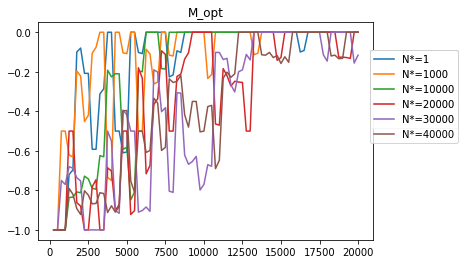

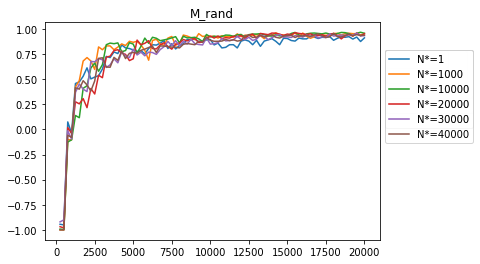

In [11]:
## Question 13
random.seed(2022)
np.random.seed(2023)
e_min = 0.1
e_max = 0.8
N = 20000
N_star_vec = [1,1000, 10000, 20000, 30000,40000]

plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

for N_star in N_star_vec:
  epsilon = []
  for i in np.arange(1,N+1):
      epsilon.append(max(e_min,e_max*(1-i/N_star)))

  dqn = DQLearning(epsilon = epsilon, test = True)
  M_rand, M_opt = dqn.training()
  print('N_star =' + str(N_star) + ' M_opt mean ' + str(np.mean(M_opt[40:])))
  print('N_star =' + str(N_star) + ' M_rand mean ' + str(np.mean(M_rand[40:])))
  ax1.plot(np.arange(1,len(M_opt)+1)*250, M_opt, label = 'N*='+str(N_star))
  ax1.set_title('M_opt')
  plt1.legend(bbox_to_anchor=(0.88,0.8), loc="upper left")
  ax1.grid()
  ax2.plot(np.arange(1,len(M_rand)+1)*250, M_rand, label = 'N*='+str(N_star))
  plt2.legend(bbox_to_anchor=(0.9,0.8), loc="upper left")
  ax2.grid()
  ax2.set_title('M_rand')

In [ ]:
## Question 14
random.seed(2022)
np.random.seed(2023)
e_min = 0.1
e_max = 0.8
N = 20000
N_star = 10000 # DA SCEGLIERE
plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()
epsilon = []
for i in np.arange(1,N+1):
    epsilon.append(max(e_min,e_max*(1-i/N_star)))

eps_opt = [0, 0.2, 0.4, 0.6, 0.8, 1]
for eps in eps_opt:
    dqn = DQLearning(epsilon_opponent = eps, epsilon = epsilon, test = True)
    M_rand, M_opt = dqn.training()
    print('epsilon=' + str(eps) + ' M_opt mean ' + str(np.mean(M_opt[40:])))
    print('epsilon=' + str(eps) + ' M_rand max ' + str(np.max(M_rand)))
    print('epsilon=' + str(eps) + ' M_rand mean ' + str(np.mean(M_rand[40:])))
    ax1.plot(np.arange(1,len(M_opt)+1)*250, M_opt, label = 'eps='+str(eps))
    ax2.plot(np.arange(1,len(M_rand)+1)*250, M_rand, label = 'eps='+str(eps))
       
plt1.legend(bbox_to_anchor=(0.88,0.8), loc="upper left")
ax1.grid()
ax1.set_title('M_opt')  
plt2.legend(bbox_to_anchor=(0.9,0.8), loc="upper left")
ax2.grid()
ax2.set_title('M_rand') 

Update target network at episode 500
Update target network at episode 1000
Update target network at episode 1500
Update target network at episode 2000
Update target network at episode 2500
Update target network at episode 3000
Update target network at episode 3500
Update target network at episode 4000
Update target network at episode 4500
Update target network at episode 5000
Update target network at episode 5500
Update target network at episode 6000
Update target network at episode 6500
Update target network at episode 7000
Update target network at episode 7500
Update target network at episode 8000
Update target network at episode 8500
Update target network at episode 9000
Update target network at episode 9500
Update target network at episode 10000
Update target network at episode 10500
Update target network at episode 11000
Update target network at episode 11500
Update target network at episode 12000
Update target network at episode 12500
Update target network at episode 13000
Update

In [ ]:
class SelfDQLearning:
  """
  Class implementing the Deep Q-learning algorithm (DQN) for the agent playing against itself
  """
  def __init__(self, epsilon, epsilon_opponent = 0.5, alpha = 5e-4, gamma = 0.99, player_name = 'O', N = 20000, n_train = 250, n_test = 500, buffer_size = 10000, batch_size = 64, test = True):
    self.epsilon = epsilon #exploration rate
    self.alpha = alpha #learning rate
    self.gamma = gamma #discount factor
    self.dq_player1 = DQPlayer(epsilon) #dq player 1
    self.dq_player2 = DQPlayer(epsilon) #dq player 2
    self.opponent = OptimalPlayer(epsilon_opponent) #optimal player, for test
    self.env = TictactoeEnv() 

    self.optimizer = keras.optimizers.Adam(learning_rate = self.alpha)
    self.N = N #total number of training games
    self.n_train = n_train #number of training games between test
    self.n_test = n_test #number of test games
    self.test = test #bool, true if you want to compute M_rand and M_opt
    self.batch_size = batch_size
    
    self.action_history = [] #vector collecting consecutive actions
    self.state_history = []  #vector collecting consecutive states 
    self.state_next_history = [] #vector collecting consecutive (next) states.
    self.rewards_history = [] #vector collecting consecutive history
    self.done_history = [] #vector collecting consecutive values of self.env.end

    self.M_rand = []
    self.M_opt = []

    self.episode_count = 0 # game counter
    self.num_actions = 9 # number of actions available

    self.max_memory_length = buffer_size # buffer size
    self.update_target_network = 500 # how often to update the target network
    self.model = Net()
    self.model_target = Net()
    self.loss_function = keras.losses.Huber() # Huber loss

  def build_tensor(self, grid, player_name):
      """
      Functions that builds the tensor from the current grid.
      INPUTS:
      - grid: current grid
      - player_name: name of the dq-player 
      """
      my_state = grid.copy()
      opp_state = grid.copy()
      if player_name == 'X':
        my_state[my_state ==-1.] = 0.
        opp_state[opp_state==1.] = 0.
        opp_state[opp_state==-1.] = 1.
      if player_name == 'O':
        my_state[my_state==1.] = 0.
        my_state[my_state==-1.] = 1.
        opp_state[opp_state==-1.] = 0.

      my_tstate = tf.convert_to_tensor(my_state)
      opp_tstate = tf.convert_to_tensor(opp_state)

      ret_tensor = tf.stack([my_tstate,opp_tstate], axis = 2)

      ret_tensor = tf.reshape(ret_tensor, shape = [1,3,3,2])

      return ret_tensor

    
  def training(self):
    """
    Functions that runs self.N training games. If self.test = true, it runs self.n_test every self.n_train trainings.
    """
    self.episode_count = 0
    while True:  # Run until solved, i.e. while episode_count < N
        self.dq_player1.set_epsilon(self.epsilon[self.episode_count])
        self.dq_player2.set_epsilon(self.epsilon[self.episode_count])
        self.episode_count += 1
        done = False

        #switch of the player names
        self.dq_player1.set_player('O', self.episode_count)
        self.dq_player2.set_player('X', self.episode_count+1)
        
        #first state = empty grid
        state1,_,_=self.env.reset()
        state_next1 = state1 #later re-defined
        current_player = self.env.current_player
        state_tensor = self.build_tensor(state1, self.env.current_player)

        #choice of the first action
        if self.dq_player1.epsilon > np.random.rand(1)[0]:
                # Take random action
                action1 = np.random.choice(self.num_actions)
        else:
                # Predict action Q-values
                action_values = self.model(state_tensor, training=False)
                # Take best action
                idx = np.argwhere(action_values[0].numpy() == np.amax(action_values[0].numpy()))[:,0]
                action1 = random.choice(idx)

        state2,_,_ = self.env.step(int(action1))
        state_tensor = self.build_tensor(state2, self.env.current_player)

        #choice of the second action
        if self.dq_player1.epsilon > np.random.rand(1)[0]:
                # Take random action
                action2 = np.random.choice(self.num_actions)
        else:
                # Predict action Q-values
                action_values = self.model(state_tensor, training=False)
                # Take best action
                idx = np.argwhere(action_values[0].numpy() == np.amax(action_values[0].numpy()))[:,0]
                action2 = random.choice(idx)


        while not done: # while the game is not over

          not_current_player = np.setdiff1d(["X","O"], [current_player])[0] 
          
          #check if action2 is available, otherwise self.env.end = true
          try:
            state_next1,_,_ = self.env.step(int(action2))
          except ValueError:
            self.env.end = True
            self.env.winner = current_player  #set the winner to be the opposite of the current player        

          if self.env.end: 
            self.action_history.append(action2)
            self.state_history.append(self.build_tensor(state2, not_current_player))
            self.state_next_history.append(self.build_tensor(self.env.grid, not_current_player))
            self.done_history.append(self.env.end)
            self.rewards_history.append(self.env.reward(not_current_player))


          done = self.env.end
          reward = self.env.reward(current_player)
          self.action_history.append(action1)
          self.state_history.append(self.build_tensor(state1, current_player))
          self.state_next_history.append(self.build_tensor(state_next1, current_player))
          self.done_history.append(self.env.end)
          self.rewards_history.append(self.env.reward(current_player))

          #updates of the actions and states
          action1 = action2
          state1 = state2 
          state2 = state_next1
          if not done: 
            state_tensor = self.build_tensor(state2, current_player)

          current_player = not_current_player

          #next action  
          if not self.env.end:
            if self.dq_player1.epsilon > np.random.rand(1)[0]:
                    # Take random action
                    action2 = np.random.choice(self.num_actions)
            else:
                    # Predict action Q-values
                    action_values = self.model(state_tensor, training=False)
                    # Take best action
                    idx = np.argwhere(action_values[0].numpy() == np.amax(action_values[0].numpy()))[:,0]
                    action2 = random.choice(idx)

          #training 
          if len(self.action_history) > self.batch_size:

              # Get indices of samples for replay buffers
              indices = np.random.choice(range(len(self.action_history)), size=self.batch_size)
              rewards_sample = self.rewards_history[0]

              # Using list comprehension to sample from replay buffer

              state_sample = tf.squeeze(np.array([self.state_history[i] for i in indices]))
              state_next_sample = tf.squeeze(np.array([self.state_next_history[i] for i in indices]))
              if self.batch_size == 1:
                state_sample = tf.expand_dims(state_sample, axis = 0)
                state_next_sample = tf.expand_dims(state_next_sample, axis = 0)
                
              rewards_sample = [self.rewards_history[i] for i in indices]
              action_sample = [self.action_history[i] for i in indices]

              done_sample = tf.convert_to_tensor([float(self.done_history[i]) for i in indices])

              masks = tf.one_hot(action_sample, 9)
              
              with tf.GradientTape() as tape:
                  prediction = self.model(state_sample)
                  prediction = tf.reduce_sum(tf.multiply(prediction, masks), axis=1)
                  future_rewards = self.model_target(state_next_sample).numpy()
                  target = rewards_sample + self.gamma * (1-done_sample) * np.max(future_rewards, axis = 1)

                  # Backpropagation
                  grads = tape.gradient(loss, self.model.trainable_variables)
                  self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

          if len(self.rewards_history) > self.max_memory_length:
            del self.rewards_history[:1]
            del self.state_history[:1]
            del self.state_next_history[:1]
            del self.action_history[:1]
            del self.done_history[:1]
          
          if done: 
            break
        #update target model
        if self.episode_count % self.update_target_network == 0:
            # update the the target network with new weights
            self.model_target.set_weights(self.model.get_weights())
            # Log details
            template = "Update target network at episode {}"
            print(template.format(self.episode_count))

        #test if self.test = true
        if self.episode_count % self.n_train == 0 and self.test:
            self.test_games(n_test = self.n_test)
            self.opponent.epsilon = 0.5
        
        if self.episode_count % 2500 == 0:
          self.alpha = 0.1*self.alpha
          self.optimizer = keras.optimizers.Adam(learning_rate = self.alpha)

        if self.episode_count >= self.N :
          print("Done {} training games".format(self.N))
          return self.M_rand, self.M_opt


  def test_games(self, eps_dq_player = 0., n_test = 500):
      """
      Function to play n test games
      INPUTS:
      - eps_dq_player: exploration level of dq_player
      - n_test: number of test games
      """
      rewards_rand = 0
      rewards_opt = 0
      for i in range(n_test):
        self.dq_player1.set_player('O',i)
        self.opponent.set_player('X',i)
        new_game = self.game_test(eps_dq_player, 1.)
        #if new_game == 1.:
          #print('vinto')
        rewards_rand += new_game      
        rewards_opt += self.game_test(eps_dq_player, 0.)
      rewards_rand = rewards_rand/n_test
      rewards_opt = rewards_opt/n_test
      self.M_rand.append(rewards_rand)
      self.M_opt.append(rewards_opt)

  def game_test(self, eps_dq_player = 0., eps_opponent = 0.):
        """
        Function to play a test game
        INPUTS:
        - eps_q_player: exploration level of q_player
        - eps_opponent: exploration level of opponent
        """
        self.env.reset() # reset the board
        #setting exploration levels
        self.dq_player1.epsilon = eps_dq_player
        self.opponent.epsilon = eps_opponent
        #print('eps opp test', self.opponent.epsilon)
        while not self.env.end: # while the game is not over
            
          if self.env.current_player == self.dq_player1.player_name :
                # action of the q_player
                state_tensor = self.build_tensor(self.env.grid.copy(),self.dq_player1.player_name)

                if self.dq_player1.epsilon > np.random.rand(1)[0]: action = np.random.choice(self.num_actions)
                else:
                  # Predict action Q-values
                  action_values = self.model_target(state_tensor, training=False)
                  # Take best action
                  action = tf.argmax(action_values[0]).numpy()
                try:
                  self.env.step(int(action))
                except ValueError:
                    self.env.end = True
                    self.env.winner = self.opponent.player
          else:
              # action of the opponent
              move_opp = self.opponent.act(self.env.grid)
              self.env.step(move_opp)

        # return reward of the q-player
        return self.env.reward(self.dq_player1.player_name)
        

Update target network at episode 500
Update target network at episode 1000
Update target network at episode 1500
Update target network at episode 2000
Update target network at episode 2500
Update target network at episode 3000
Update target network at episode 3500
Update target network at episode 4000
Update target network at episode 4500
Update target network at episode 5000
Update target network at episode 5500
Update target network at episode 6000
Update target network at episode 6500
Update target network at episode 7000
Update target network at episode 7500
Update target network at episode 8000
Update target network at episode 8500
Update target network at episode 9000
Update target network at episode 9500
Update target network at episode 10000
Update target network at episode 10500
Update target network at episode 11000
Update target network at episode 11500
Update target network at episode 12000
Update target network at episode 12500
Update target network at episode 13000
Update

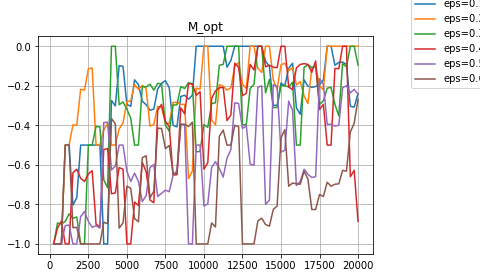

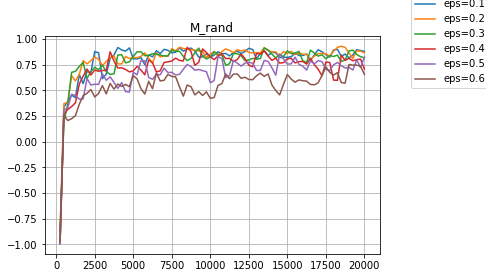

In [ ]:
## Question 16
np.random.seed(2022)
random.seed(2023)
eps_vector = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
rew_epsilon = []


n_train = 250
n_test = 500
N = 20000

plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

ax1.set_title('M_opt')
ax2.set_title('M_rand')

for epsilon in eps_vector:
    sdql = SelfDQLearning(epsilon*np.ones([N,1]), N = N, n_train = n_train,  test = True, n_test = n_test, alpha = 5e-4)
    M_rand_vec, M_opt_vec = sdql.training()
    ax1.plot(np.arange(1,len(M_opt_vec)+1)*250, M_opt_vec, label = 'eps='+str(epsilon))
    ax2.plot(np.arange(1,len(M_rand_vec)+1)*250, M_rand_vec, label = 'eps='+str(epsilon))

ax1.grid()
ax2.grid()

plt1.legend(bbox_to_anchor=(0.94,1), loc="upper left")
plt2.legend(bbox_to_anchor=(0.94,1), loc="upper left")


In [ ]:
## Question 17
random.seed(2022)
np.random.seed(2023)
n_train = 250
n_test = 500
e_min = 0.1
e_max = 0.8
N = 20000
N_star_vec = [1,10,100, 1000, 10000, 15000, 20000, 30000,40000]
batch_size = 64
buffer_size = 10000


plt1, ax1 = plt.subplots()
plt2, ax2 = plt.subplots()

for N_star in N_star_vec:
  epsilon = []
  for i in np.arange(1,N+1):
      epsilon.append(max(e_min,e_max*(1-i/N_star)))
  sdqn = SelfDQLearning(epsilon = epsilon, N = N, n_train = n_train, test = True, n_test = n_test, alpha = 5e-4)
  M_rand, M_opt = sdqn.training()
  #print('N_star =' + str(N_star) + ' M_opt mean ' + str(np.mean(M_opt[40:])))
  #print('N_star =' + str(N_star) + ' M_rand mean ' + str(np.mean(M_rand[40:])))
  ax1.plot(np.arange(1,len(M_opt)+1)*250, M_opt, label = 'N*='+str(N_star))
  ax1.set_title('M_opt')
  plt1.legend(bbox_to_anchor=(0.88,0.8), loc="upper left")
  ax1.grid()
  ax2.plot(np.arange(1,len(M_rand)+1)*250, M_rand, label = 'N*='+str(N_star))
  plt2.legend(bbox_to_anchor=(0.9,0.8), loc="upper left")
  ax2.grid()
  ax2.set_title('M_rand')

Update target network at episode 500
Update target network at episode 1000
Update target network at episode 1500
Update target network at episode 2000
Update target network at episode 2500
Update target network at episode 3000
Update target network at episode 3500
Update target network at episode 4000
Update target network at episode 4500
Update target network at episode 5000
Update target network at episode 5500
Update target network at episode 6000
Update target network at episode 6500
Update target network at episode 7000
Update target network at episode 7500
Update target network at episode 8000
Update target network at episode 8500
Update target network at episode 9000
Update target network at episode 9500
Update target network at episode 10000
Update target network at episode 10500
Update target network at episode 11000
Update target network at episode 11500
Update target network at episode 12000
Update target network at episode 12500
Update target network at episode 13000
Update